<a href="https://colab.research.google.com/github/windyrahayu45/Proyek-Analisis-Sentimen/blob/main/Sentimen_Shopee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd
import time
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Pastikan stopwords bahasa Indonesia tersedia
nltk.download("stopwords")
stop_words = set(stopwords.words("indonesian"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Shop ID dan Item ID dari URL produk Shopee
SHOP_ID = 468947139
ITEM_ID = 23878205368
MAX_REVIEWS = 10000  # Target minimal 10.000 data
LIMIT = 50

# Set Header & Cookies dari Browser
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36",
    "Referer": f"https://shopee.co.id/product/{SHOP_ID}/{ITEM_ID}/",
}

# Fungsi scraping dengan session
def scrape_shopee_reviews(shop_id, item_id, max_reviews=10000):
    session = requests.Session()
    session.headers.update(HEADERS)

    reviews = []
    offset = 0

    while len(reviews) < max_reviews:
        print(f"🔄 Mengambil data dari offset {offset}...")
        url = f"https://shopee.co.id/api/v2/item/get_ratings?itemid={item_id}&shopid={shop_id}&offset={offset}&limit={LIMIT}&type=0"

        try:
            response = session.get(url)
            if response.status_code != 200:
                print("⚠️ Gagal mengambil data, status code:", response.status_code)
                break

            data = response.json()
            if "data" in data and "ratings" in data["data"]:
                for review in data["data"]["ratings"]:
                    reviews.append({
                        "Username": review.get("author_username", ""),
                        "Rating": review.get("rating_star", 0),
                        "Komentar": review.get("comment", "")
                    })

            offset += LIMIT
            if len(data["data"]["ratings"]) < LIMIT:
                break

            time.sleep(1)

        except Exception as e:
            print("⚠️ Terjadi kesalahan:", str(e))
            break

    return pd.DataFrame(reviews)

# Jalankan scraping
df_reviews = scrape_shopee_reviews(SHOP_ID, ITEM_ID, MAX_REVIEWS)

# Simpan hasil scraping sebelum preprocessing
df_reviews.to_csv("shopee_reviews_raw.csv", index=False)
print("✅ Data mentah telah disimpan sebagai 'shopee_reviews_raw.csv'.")

🔄 Mengambil data dari offset 0...
🔄 Mengambil data dari offset 50...
🔄 Mengambil data dari offset 100...
🔄 Mengambil data dari offset 150...
🔄 Mengambil data dari offset 200...
🔄 Mengambil data dari offset 250...
🔄 Mengambil data dari offset 300...
🔄 Mengambil data dari offset 350...
🔄 Mengambil data dari offset 400...
🔄 Mengambil data dari offset 450...
🔄 Mengambil data dari offset 500...
🔄 Mengambil data dari offset 550...
🔄 Mengambil data dari offset 600...
🔄 Mengambil data dari offset 650...
🔄 Mengambil data dari offset 700...
🔄 Mengambil data dari offset 750...
🔄 Mengambil data dari offset 800...
🔄 Mengambil data dari offset 850...
🔄 Mengambil data dari offset 900...
🔄 Mengambil data dari offset 950...
🔄 Mengambil data dari offset 1000...
🔄 Mengambil data dari offset 1050...
🔄 Mengambil data dari offset 1100...
🔄 Mengambil data dari offset 1150...
🔄 Mengambil data dari offset 1200...
🔄 Mengambil data dari offset 1250...
🔄 Mengambil data dari offset 1300...
🔄 Mengambil data dari of

In [3]:
# Fungsi preprocessing teks
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # Hapus URL
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)  # Hapus karakter spesial
    text = re.sub(r"\s+", " ", text).strip()  # Hapus spasi berlebih
    text = " ".join([word for word in text.split() if word not in stop_words])  # Hapus stopwords
    return text

# Fungsi labeling sentimen
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 2  # Positif
    elif analysis.sentiment.polarity < 0:
        return 0  # Negatif
    else:
        return 1  # Netral

# Preprocessing data
df_reviews["Komentar"] = df_reviews["Komentar"].apply(clean_text)

# Labeling sentimen
df_reviews["Sentimen"] = df_reviews["Komentar"].apply(get_sentiment)

# Simpan hasil scraping ke CSV
df_reviews.to_csv("shopee_reviews_cleaned.csv", index=False)
print("✅ Data telah disimpan sebagai 'shopee_reviews_cleaned.csv'.")

✅ Data telah disimpan sebagai 'shopee_reviews_cleaned.csv'.


<ipython-input-4-708ba247fad1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_reviews["Sentimen"], palette="viridis")


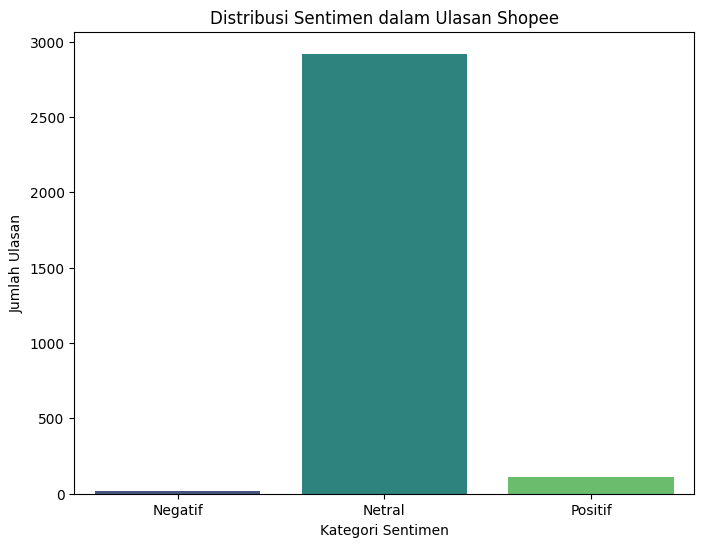

In [4]:
# Visualisasi distribusi polaritas sentimen
plt.figure(figsize=(8, 6))
sns.countplot(x=df_reviews["Sentimen"], palette="viridis")
plt.xticks(ticks=[0, 1, 2], labels=["Negatif", "Netral", "Positif"])
plt.title("Distribusi Sentimen dalam Ulasan Shopee")
plt.xlabel("Kategori Sentimen")
plt.ylabel("Jumlah Ulasan")
plt.show()

In [5]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_reviews["Komentar"])
y = df_reviews["Sentimen"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Algoritma Machine Learning & Deep Learning
models = {
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Evaluasi Model
results = []
for name, model in models.items():
    print(f"\n🔍 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Akurasi {name}: {acc * 100:.2f}%")
    print(classification_report(y_test, y_pred))
    results.append([name, acc * 100])

# Simpan hasil evaluasi ke CSV
df_results = pd.DataFrame(results, columns=["Model", "Accuracy"])
df_results.to_csv("model_evaluation.csv", index=False)
print("✅ Hasil evaluasi disimpan sebagai 'model_evaluation.csv'.")



🔍 Training Naive Bayes...
✅ Akurasi Naive Bayes: 95.74%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.96      1.00      0.98       584
           2       0.00      0.00      0.00        24

    accuracy                           0.96       610
   macro avg       0.32      0.33      0.33       610
weighted avg       0.92      0.96      0.94       610


🔍 Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Akurasi Random Forest: 96.89%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.97      1.00      0.98       584
           2       1.00      0.29      0.45        24

    accuracy                           0.97       610
   macro avg       0.66      0.43      0.48       610
weighted avg       0.97      0.97      0.96       610


🔍 Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Akurasi Logistic Regression: 95.90%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.96      1.00      0.98       584
           2       1.00      0.04      0.08        24

    accuracy                           0.96       610
   macro avg       0.65      0.35      0.35       610
weighted avg       0.96      0.96      0.94       610


🔍 Training Decision Tree...
✅ Akurasi Decision Tree: 99.02%
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.99      1.00      1.00       584
           2       0.91      0.88      0.89        24

    accuracy                           0.99       610
   macro avg       0.80      0.79      0.80       610
weighted avg       0.99      0.99      0.99       610


🔍 Training Neural Network...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Akurasi Neural Network: 96.23%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.96      1.00      0.98       584
           2       1.00      0.12      0.22        24

    accuracy                           0.96       610
   macro avg       0.65      0.38      0.40       610
weighted avg       0.96      0.96      0.95       610

✅ Hasil evaluasi disimpan sebagai 'model_evaluation.csv'.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
